In [1]:
print("hola mundo")

hola mundo


## **Importación de bibliotecas**

A continuación, se describen las bibliotecas utilizadas en el desarrollo del modelo:

- **os**: Permite interactuar con el sistema operativo, útil para manejar archivos y directorios en la carga de datos.
- **torch**: Librería principal de PyTorch para el desarrollo y entrenamiento de modelos de aprendizaje profundo.
- **torch.nn**: Proporciona módulos y funciones para construir redes neuronales en PyTorch.
- **torch.optim**: Contiene optimizadores utilizados para entrenar modelos mediante descenso de gradiente.
- **pandas**: Se utiliza para manipulación y análisis de datos tabulares, como la carga de etiquetas desde archivos CSV.
- **torchvision.transforms**: Ofrece transformaciones para preprocesar imágenes antes de ingresarlas al modelo.
- **PIL (Python Imaging Library)**: Se usa para cargar y manipular imágenes en diferentes formatos.
- **torch.utils.data (Dataset y DataLoader)**: Facilita la gestión de los conjuntos de datos y su alimentación al modelo en lotes.
- **itertools**: Proporciona herramientas para iteraciones eficientes, útil para combinaciones o permutaciones de datos.
- **torchvision.models (efficientnet_v2_s)**: Se importa el modelo preentrenado EfficientNetV2-S, que se usará como base para la clasificación.
- **torch.nn.functional**: Contiene funciones útiles como activaciones, pérdidas y operaciones sobre tensores.

### **Uso en el notebook**
Estas bibliotecas permiten construir un pipeline de aprendizaje profundo que incluye:
1. **Carga y preprocesamiento de datos**: Se usa `os`, `pandas`, `PIL`, y `torchvision.transforms` para leer imágenes y etiquetas.
2. **Definición del modelo**: Se emplea `torch.nn` y `efficientnet_v2_s` para crear la red neuronal.
3. **Entrenamiento**: `torch.optim` y `torch.nn.functional` ayudan a definir el proceso de optimización y la función de pérdida.
4. **Evaluación y predicción**: Se aplican las herramientas de PyTorch para evaluar el modelo y generar predicciones sobre datos de prueba.

---


In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import itertools
from torchvision.models import efficientnet_v2_s
import torch.nn.functional as F

## **Carga y organización de datos**

En esta sección, organizamos los conjuntos de datos para entrenamiento, validación y prueba.  
Los datos provienen del desafío **BreastPathQ 2019** y están estructurados en imágenes de parches histológicos junto con sus etiquetas.

### **1️ Directorios de imágenes**
- **`train_image_dir`**: Contiene las imágenes de entrenamiento con sus etiquetas.
- **`val_image_dir`**: Contiene las imágenes de validación con sus etiquetas.
- **`test_image_dir`**: Contiene las imágenes de prueba (sin etiquetas).

### **2️ Rutas de etiquetas**
- **`train_label_path`**: Archivo CSV con etiquetas de entrenamiento.
- **`val_label_path`**: Archivo CSV con etiquetas de validación.

---

## **Procesamiento de los conjuntos de datos**

1. **Entrenamiento (`df_train`)**
   - Se carga el CSV de entrenamiento.
   - Se genera el nombre de cada imagen combinando `slide` y `rid`.
  
2. **Validación (`df_val`)**
   - Se listan todas las imágenes del directorio de validación.
   - Se extrae el `slide` y `rid` del nombre del archivo.
   - Se unen estos datos con el CSV de etiquetas.

3. **Prueba (`df_test`)**
   - Se listan todas las imágenes del directorio de prueba.
   - Se extrae el `slide` y `rid` del nombre del archivo.
   - **(Importante)** No hay etiquetas en este conjunto.

---

## **Diagrama de distribución de imagenes en los conjuntos de datos**
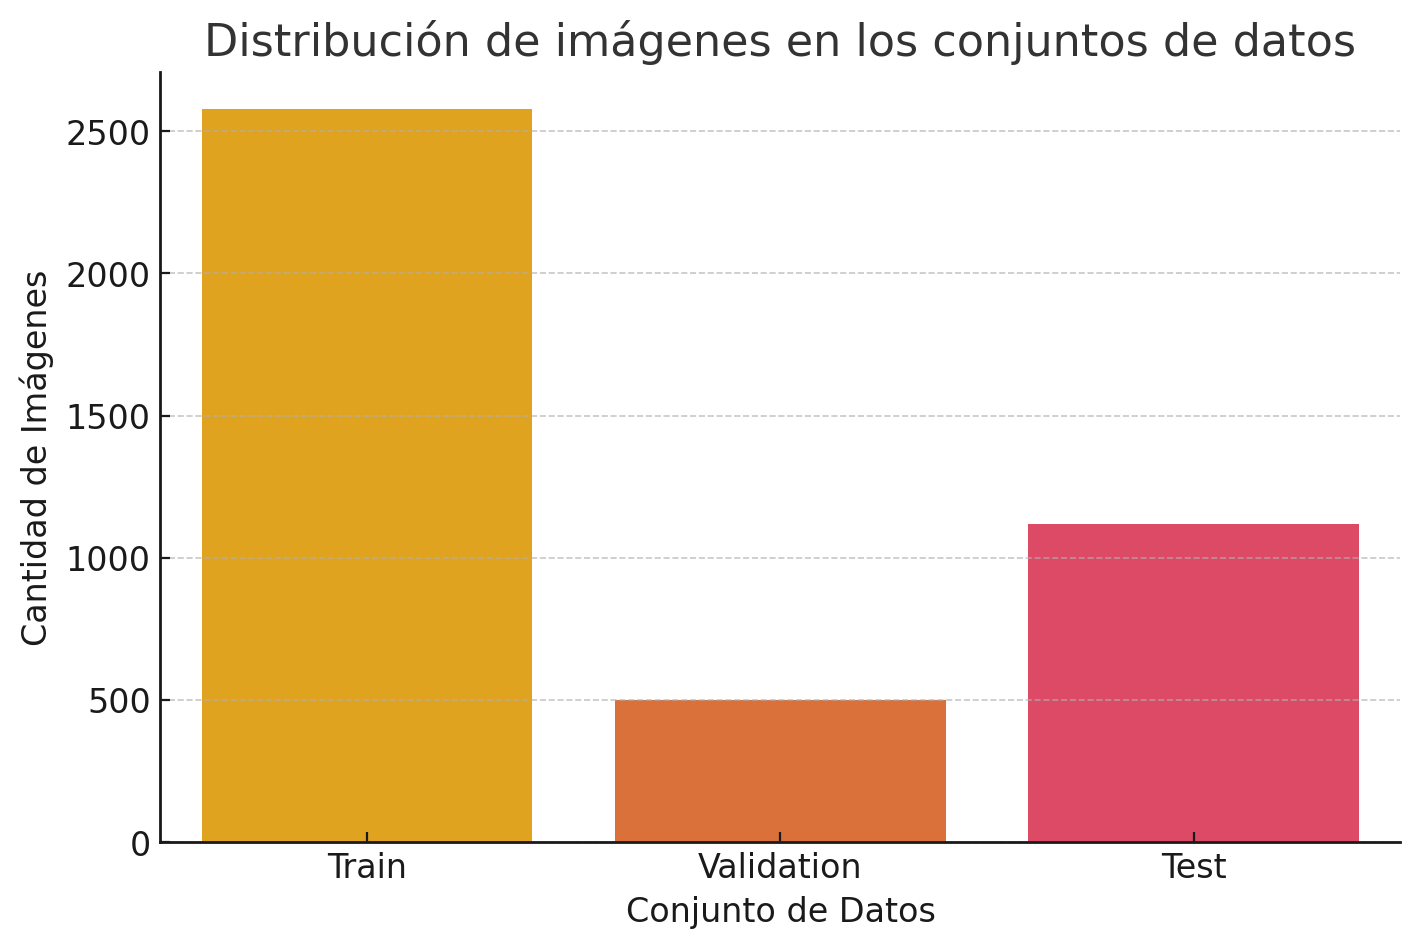


---


In [3]:
# Directorios de imágenes
train_image_dir = "datasets/SPIE_BreastPathQ2019_Training_Validation/breastpathq/datasets/train"
val_image_dir = "datasets/SPIE_BreastPathQ2019_Training_Validation/breastpathq/datasets/validation"
test_image_dir = "datasets/SPIE_BreastPathQ2019_Testing/breastpathq-test/test_patches"

# Rutas de etiquetas
train_label_path = "datasets/SPIE_BreastPathQ2019_Training_Validation/breastpathq/datasets/train_labels.csv"
val_label_path = "datasets/SPIE_BreastPathQ2019_Testing/breastpathq-test/val_labels.csv"

# Cargar datos
df_train = pd.read_csv(train_label_path)
df_train["image_name"] = df_train["slide"].astype(str) + "_" + df_train["rid"].astype(str) + ".tif"

val_images = [f for f in os.listdir(val_image_dir) if f.endswith(".tif")]
df_val = pd.DataFrame({"image_name": val_images})
df_val[["slide", "rid"]] = df_val["image_name"].str.extract(r'(\d+)_(\d+).tif').astype(int)
df_val_labels = pd.read_csv(val_label_path)
df_val = df_val.merge(df_val_labels, on=["slide", "rid"], how="left")

test_images = [f for f in os.listdir(test_image_dir) if f.endswith(".tif")]
df_test = pd.DataFrame({"image_name": test_images})
df_test[["slide", "rid"]] = df_test["image_name"].str.extract(r'(\d+)_(\d+).tif').astype(int)

# Resumen de conjuntos de datos
print("Organización Final de Conjuntos:")
print(f"Train: {len(df_train)} imágenes")
print(f"Validation: {len(df_val)} imágenes")
print(f"Test_patches: {len(df_test)} imágenes (Debe ser 1119)")


Organización Final de Conjuntos:
Train: 2394 imágenes
Validation: 185 imágenes
Test_patches: 1119 imágenes (Debe ser 1119)


## **Exploración de Datos y Transformación de Imágenes**

En esta sección, se define la clase `BreastDataset`, que nos permite organizar y acceder a las imágenes del dataset de cáncer de mama. Además, se aplican transformaciones a las imágenes para normalizarlas y adaptarlas al modelo de clasificación.

### **Definición de la Clase `BreastDataset`**

Esta clase hereda de `torch.utils.data.Dataset` y tiene los siguientes métodos:

- **`__init__(self, df, image_dir, transform=None, is_test=False)`**:  
  - Recibe un DataFrame con la información de las imágenes (`df`).
  - Recibe la ruta donde están almacenadas las imágenes (`image_dir`).
  - Opcionalmente, recibe una transformación (`transform`) que se aplicará a las imágenes antes de ingresarlas al modelo.
  - El parámetro `is_test` indica si el dataset pertenece al conjunto de prueba (sin etiquetas).

- **`__len__(self)`**:  
  - Devuelve la cantidad de imágenes en el dataset.

- **`__getitem__(self, idx)`**:  
  - Carga una imagen específica basada en su índice `idx`.
  - Aplica las transformaciones definidas si están presentes.
  - Si `is_test=True`, devuelve solo la imagen y su nombre (sin etiqueta).  
  - En caso contrario, devuelve la imagen junto con su etiqueta (`y`).

---

### **Transformaciones aplicadas a las imágenes**

Se define una serie de transformaciones en la variable `transform`, utilizando `torchvision.transforms`:

1. **Redimensionado**:  
   - `transforms.Resize((300, 300))`: Escala todas las imágenes a 300x300 píxeles para que el modelo las procese correctamente.
   
2. **Conversión a tensor**:  
   - `transforms.ToTensor()`: Convierte la imagen a un tensor, necesario para PyTorch.
   
3. **Normalización**:  
   - `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Ajusta los valores de los píxeles para que el modelo preentrenado (EfficientNetV2) los procese mejor.

---

### **Valores de normalización basados en ImageNet**

Estos valores no son elegidos al azar. Se basan en las estadísticas de las imágenes del conjunto de datos ImageNet, un dataset masivo utilizado para entrenar muchos modelos de visión artificial, incluyendo EfficientNetV2.

1. **¿Qué significan estos valores?**

   - **mean=[0.485, 0.456, 0.406]**: Son los valores promedio (media) de los canales Rojo (R), Verde (G) y Azul (B) en todas las imágenes de ImageNet.
   - **std=[0.229, 0.224, 0.225]**: Representan la desviación estándar de cada canal en el conjunto de ImageNet.

2. **¿Por qué se normalizan las imágenes con estos valores?**

   Los modelos preentrenados como EfficientNetV2 han sido entrenados con imágenes que ya estaban normalizadas con estos valores de ImageNet. Cuando usamos este modelo para nuestro problema, queremos que las imágenes de nuestro dataset tengan una distribución de píxeles similar a la de las imágenes con las que EfficientNetV2 fue entrenado. Esto tiene varios beneficios:

   - **Compatibilidad con el modelo**: EfficientNetV2 fue entrenado esperando imágenes con esta normalización, por lo que al usar los mismos valores, aseguramos que nuestro modelo procese los datos correctamente.
   - **Asegurar que las imágenes tengan una escala uniforme**: Sin normalización, los valores de los píxeles de las imágenes originales pueden estar entre 0 y 255 (escala RGB), lo que podría generar problemas numéricos al entrenar una red neuronal. Al normalizar, los valores se transforman a una distribución con media cercana a 0 y varianza cercana a 1, lo que ayuda a estabilizar el entrenamiento.
   - **Facilitar la convergencia del modelo**: Al normalizar, evitamos que algunos canales dominen sobre otros, reduciendo el riesgo de que el modelo aprenda patrones sesgados debido a diferencias en escala entre los valores de píxeles.

3. **¿Qué pasa si no normalizamos?**

   Si no aplicamos esta normalización:

   - Los valores de los píxeles seguirían en el rango [0, 255] o [0, 1] (si solo usamos `ToTensor()`), lo que haría que el modelo tenga dificultades para hacer predicciones precisas.
   - La red podría tardar más en aprender, porque tendría que ajustarse a datos con una escala diferente a la que usó en su entrenamiento inicial.
   - En algunos casos, el modelo podría dar resultados inconsistentes o con menor precisión.

4. **¿Cómo afecta visualmente la imagen transformada?**

   En la imagen transformada:

   - Vemos un aumento del contraste, lo que hace que las estructuras celulares sean más evidentes.
   - Los tonos pueden parecer más saturados o distintos, ya que la normalización ajusta los valores de los píxeles en función de la distribución esperada por el modelo.

---

In [4]:
class BreastDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, is_test=False):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["image_name"]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, img_name
        else:
            label = self.df.iloc[idx]["y"]
            return image, torch.tensor(label, dtype=torch.float32)

# Transformaciones para EfficientNetV2
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets y dataloaders
train_dataset = BreastDataset(df_train, train_image_dir, transform)
val_dataset = BreastDataset(df_val, val_image_dir, transform)
test_dataset = BreastDataset(df_test, test_image_dir, transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


## **Comparación de Imágenes: Original vs Transformada**

En esta sección, se selecciona una imagen aleatoria del conjunto de entrenamiento para visualizar cómo se ve antes y después de aplicar las transformaciones definidas. Esto nos permite entender el impacto de las transformaciones en la imagen y cómo se preparan los datos para el modelo.

### **Proceso de Comparación**

1. **Selección de una imagen aleatoria**:  
   - Se elige un índice aleatorio dentro del dataset de entrenamiento utilizando `random.randint`.
   - Este índice se utiliza para obtener la imagen transformada y su etiqueta correspondiente.

2. **Carga de la imagen original**:  
   - Se obtiene la ruta de la imagen original utilizando el nombre de la imagen almacenado en el DataFrame.
   - La imagen original se carga utilizando `PIL.Image.open` y se convierte al formato RGB.

3. **Visualización de ambas imágenes**:  
   - Se crea una figura con dos subplots para mostrar la imagen original y la imagen transformada lado a lado.
   - La imagen transformada se convierte de un tensor (formato utilizado por PyTorch) a un formato RGB para su visualización.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8431373..2.6051416].


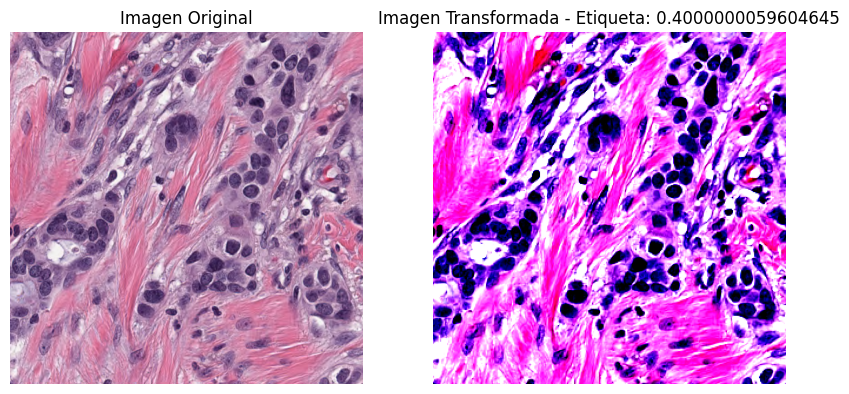

In [5]:

# Seleccionar un índice aleatorio dentro del dataset de entrenamiento
random_idx = random.randint(0, len(train_dataset) - 1)

# Obtener la imagen transformada y su etiqueta
image_transformed, label = train_dataset[random_idx]

# Obtener la ruta de la imagen original
img_name = train_dataset.df.iloc[random_idx]["image_name"]
img_path = os.path.join(train_dataset.image_dir, img_name)

# Cargar la imagen original
image_original = Image.open(img_path).convert("RGB")

# Mostrar ambas imágenes: original y transformada
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Imagen original
axes[0].imshow(image_original)
axes[0].set_title("Imagen Original")
axes[0].axis("off")

# Imagen transformada
axes[1].imshow(image_transformed.permute(1, 2, 0))  # Convertir tensor a imagen RGB
axes[1].set_title(f"Imagen Transformada - Etiqueta: {label.item()}")
axes[1].axis("off")

plt.show()


## **Modelos y Ajuste de Hiperparámetros**

En esta sección, se selecciona el modelo de aprendizaje profundo y se ajustan los hiperparámetros para optimizar su rendimiento en la tarea de cuantificación de celularidad tumoral.

---

### **1. Selección del Modelo**

Para este problema, se utiliza **EfficientNetV2-S**, un modelo preentrenado en ImageNet que ha demostrado un rendimiento sólido en tareas de clasificación de imágenes. Se aprovecha su capacidad para extraer características visuales avanzadas y se modifica su última capa para convertirlo en un modelo de regresión, ya que el objetivo es predecir una puntuación continua en lugar de una clase categórica.

#### **Justificación de la Elección del Modelo**

Según la documentación oficial de **Keras Applications**, EfficientNetV2-S presenta una buena relación entre:

- **Top-1 Accuracy en ImageNet**: Ofrece un rendimiento competitivo en tareas de clasificación (**83.9%**).
- **Consumo de recursos**: En comparación con modelos más grandes como ResNet-50 o EfficientNetV2-L, tiene menores requerimientos computacionales (peso de **88MB** y **21.6** millones de parámetros), lo que lo hace más viable para entrenar en hardware de consumo.

Dado que el hardware disponible es un **AMD Ryzen 5 3600 (6-Core, 12-Threads)**, una **GTX 1660 Ti** y **16GB de RAM**, EfficientNetV2-S es una opción adecuada, ya que:

- **Aprovecha la capacidad de la GPU** sin saturar la memoria VRAM.
- **No sobrecarga el procesador**, permitiendo un entrenamiento más eficiente.
- **Equilibra velocidad y precisión**, optimizando el tiempo de entrenamiento sin sacrificar demasiada exactitud.

---

### **2. Adaptación del Modelo**

- **Carga del modelo**:  
  Se carga el modelo **EfficientNetV2-S** con pesos preentrenados en ImageNet.

- **Modificación de la última capa**:  
  Se reemplaza la última capa completamente conectada (`classifier[1]`) con una nueva capa de salida de una sola neurona (`nn.Linear(num_ftrs, 1)`).  
  - Esto es necesario porque el modelo preentrenado originalmente estaba diseñado para clasificación de 1000 categorías, y en este caso, necesitamos una salida numérica continua para la predicción de celularidad tumoral.

- **Envío al dispositivo de cómputo**:  
  Se detecta y asigna el modelo al dispositivo de cómputo disponible (`cuda` si hay GPU, o `cpu` en caso contrario).

---

### **3. Definición de la Función de Pérdida**

Para entrenar el modelo, se usa la pérdida de **Error Cuadrático Medio (MSELoss)**, ya que estamos tratando un problema de regresión.

- **El MSE (Mean Squared Error)** mide la diferencia entre las predicciones del modelo y los valores reales, penalizando más los errores grandes.
- Es una métrica estándar en problemas donde se predicen valores continuos.

---

### **4. Optimización**

- **Optimizador**:  
  Se emplea el optimizador **Adam**, que es una variante del descenso de gradiente estocástico con un ajuste adaptativo de la tasa de aprendizaje.

- **Tasa de aprendizaje**:  
  La tasa de aprendizaje (`lr=0.0008`) fue seleccionada empíricamente para asegurar una convergencia estable sin que el modelo se estanque en mínimos locales.

---

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo en uso: {device}")

efficientnet = efficientnet_v2_s(weights="IMAGENET1K_V1")
num_ftrs = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_ftrs, 1)  # Modificar la capa final para regresión
efficientnet = efficientnet.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=0.0008)


Dispositivo en uso: cuda


## **Entrenamiento del Modelo**

El modelo se entrena por **50 épocas**, ya que EfficientNetV2 suele converger más rápido que otros modelos.

---

### **Flujo del Entrenamiento**

1. **Modo de entrenamiento**:  
   Se establece el modelo en modo de entrenamiento (`efficientnet.train()`).

2. **Inicialización de la pérdida acumulada**:  
   Se inicializa la pérdida acumulada por época para monitorear el desempeño.

3. **Iteración sobre el dataset**:  
   Se recorre el dataset en minilotes (batch), iterando sobre `train_loader`:  
   - Las imágenes y etiquetas se envían al dispositivo de cómputo (`cuda` o `cpu`).  
   - Se hace un **forward pass** del modelo para obtener las predicciones.  
   - Se calcula la pérdida **MSE** entre las predicciones y las etiquetas reales.  
   - Se realiza la **retropropagación** (`loss.backward()`) para ajustar los pesos del modelo.  
   - Se actualizan los pesos con `optimizer.step()`.  

4. **Monitoreo del progreso**:  
   Al final de cada época, se imprime la pérdida promedio para monitorear el progreso.

---

### **Objetivo del Entrenamiento**

Este proceso permite que el modelo aprenda una representación de las imágenes histopatológicas, identificando patrones relevantes que le permitan cuantificar la celularidad tumoral de manera precisa.

- **Si la pérdida sigue disminuyendo con cada época**:  
  Significa que el modelo está aprendiendo correctamente.

- **Si se observa un estancamiento o sobreajuste**:  
  Se pueden realizar ajustes en los hiperparámetros, como:  
  - Modificar la tasa de aprendizaje (`lr`).  
  - Ajustar el número de épocas (`epochs`).  

---

In [7]:
epoch_losses = []
epochs = 50  # Ajustamos a 50 ya que EfficientNetV2 aprende más rápido
for epoch in range(epochs):
    efficientnet.train()
    epoch_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Época {epoch+1}/{epochs} - Pérdida: {epoch_loss/len(train_loader):.4f}")
    avg_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)  # Guardar la pérdida promedio de la época


Época 1/50 - Pérdida: 0.0427
Época 2/50 - Pérdida: 0.0198
Época 3/50 - Pérdida: 0.0146
Época 4/50 - Pérdida: 0.0120
Época 5/50 - Pérdida: 0.0078
Época 6/50 - Pérdida: 0.0058
Época 7/50 - Pérdida: 0.0055
Época 8/50 - Pérdida: 0.0047
Época 9/50 - Pérdida: 0.0043
Época 10/50 - Pérdida: 0.0042
Época 11/50 - Pérdida: 0.0044
Época 12/50 - Pérdida: 0.0049
Época 13/50 - Pérdida: 0.0050
Época 14/50 - Pérdida: 0.0039
Época 15/50 - Pérdida: 0.0025
Época 16/50 - Pérdida: 0.0023
Época 17/50 - Pérdida: 0.0021
Época 18/50 - Pérdida: 0.0019
Época 19/50 - Pérdida: 0.0017
Época 20/50 - Pérdida: 0.0045
Época 21/50 - Pérdida: 0.0078
Época 22/50 - Pérdida: 0.0125
Época 23/50 - Pérdida: 0.0110
Época 24/50 - Pérdida: 0.0052
Época 25/50 - Pérdida: 0.0047
Época 26/50 - Pérdida: 0.0029
Época 27/50 - Pérdida: 0.0022
Época 28/50 - Pérdida: 0.0017
Época 29/50 - Pérdida: 0.0018
Época 30/50 - Pérdida: 0.0018
Época 31/50 - Pérdida: 0.0021
Época 32/50 - Pérdida: 0.0016
Época 33/50 - Pérdida: 0.0014
Época 34/50 - Pérdi

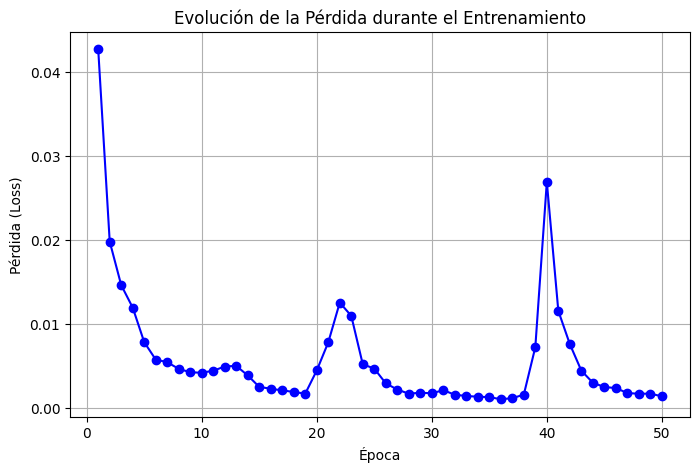

In [8]:
# Graficar la pérdida a través de las épocas
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), epoch_losses, marker="o", linestyle="-", color="b")
plt.xlabel("Época")
plt.ylabel("Pérdida (Loss)")
plt.title("Evolución de la Pérdida durante el Entrenamiento")
plt.grid(True)
plt.show()

## **Generación del Archivo de Envío**

En esta sección, se utiliza el modelo previamente entrenado para generar predicciones en el conjunto de prueba y exportarlas en el formato requerido por la competencia.

---

### **1. Cambio a Modo de Evaluación**

- El modelo se pone en modo de evaluación (`efficientnet.eval()`), lo que desactiva características como el dropout y la actualización de gradientes.
- Esto garantiza que el modelo haga inferencias consistentes y no se modifiquen sus parámetros durante la predicción.

---

### **2. Generación de Predicciones**

Se recorren las imágenes del conjunto de prueba (`test_loader`) sin calcular gradientes (`torch.no_grad()`), lo que reduce el uso de memoria y mejora la velocidad de inferencia.

Para cada lote de imágenes:

1. **Envío al dispositivo de cómputo**:  
   Las imágenes se envían al dispositivo de cómputo (`cuda` o `cpu`).

2. **Generación de predicciones**:  
   Se generan las predicciones del modelo (`efficientnet(images)`), que son valores continuos.

3. **Aplicación de la función sigmoide**:  
   Se aplica la función sigmoide (`F.sigmoid()`) para convertir la salida a un rango entre 0 y 1, asegurando que las predicciones representen probabilidades de celularidad tumoral.

4. **Extracción de nombres y predicciones**:  
   Se extraen los nombres de las imágenes y sus respectivas predicciones.

---

### **3. Creación del Archivo de Envío**

Las predicciones se almacenan en una lista estructurada con los siguientes campos:

- **slide**: Identificación del portaobjetos de la imagen.
- **rid**: Identificación única dentro del portaobjetos.
- **score**: Predicción del modelo sobre la celularidad tumoral.

Esta información se convierte en un **DataFrame de pandas** (`df_test_predictions`) y se guarda en un archivo CSV (`submission_test.csv`) en el formato requerido por la competencia.

---

### **4. Finalización y Entrega**

- Una vez generado el archivo, se imprime un mensaje confirmando su creación.
- Este archivo (`submission_test.csv`) es el que se debe subir a la plataforma de la competencia para evaluar el desempeño del modelo y obtener su puntaje en el leaderboard.

---

In [9]:
efficientnet.eval()
test_predictions = []

with torch.no_grad():
    for images, image_names in test_loader:
        images = images.to(device)
        outputs = efficientnet(images).squeeze().cpu().numpy()
        outputs = F.sigmoid(torch.tensor(outputs)).numpy()  # Convertir a [0,1]

        for img_name, pred in zip(image_names, outputs):
            slide, rid = img_name.replace(".tif", "").split("_")
            test_predictions.append([int(slide), int(rid), pred])

df_test_predictions = pd.DataFrame(test_predictions, columns=["slide", "rid", "score"])
df_test_predictions.to_csv("submission_test.csv", index=False)

print(f"Archivo de predicciones generado: submission_test.csv")


Archivo de predicciones generado: submission_test.csv


In [10]:
import torch
import itertools
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_pk(labels, predictions):
    """Calcula la métrica PK (Kendall's Tau modificada)"""
    P, Q, T = 0, 0, 0
    for (pred_i, true_i), (pred_j, true_j) in itertools.combinations(zip(predictions, labels), 2):
        if (true_i < true_j and pred_i < pred_j) or (true_i > true_j and pred_i > pred_j):
            P += 1
        elif (true_i < true_j and pred_i > pred_j) or (true_i > true_j and pred_i < pred_j):
            Q += 1
        elif pred_i == pred_j:
            T += 1
    return (((P - Q) / (P + Q + T)) + 1) / 2 if (P + Q + T) != 0 else 0

def evaluate_model(model, data_loader, criterion, device):
    """Evalúa el modelo en el conjunto de validación usando múltiples métricas"""
    model.eval()
    all_labels, all_predictions = [], []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    # Convertir a arrays de numpy para cálculo de métricas
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Cálculo de métricas
    mse = mean_squared_error(all_labels, all_predictions)
    mae = mean_absolute_error(all_labels, all_predictions)
    epsilon = 1e-8  # Pequeño valor para evitar división por cero
    mape = np.mean(np.abs((all_labels - all_predictions) / (all_labels + epsilon))) * 100       

    pk = calculate_pk(all_labels, all_predictions)

    # Mostrar resultados
    print(f"Evaluación del Modelo:")
    print(f"MSE  (Error Cuadrático Medio):  {mse:.4f}")
    print(f"MAE  (Error Absoluto Medio):   {mae:.4f}")
    print(f"MAPE (Error Relativo Medio):   {mape:.2f}%")
    print(f"PK Score:                     {pk:.4f}")

    return mse, mae, mape, pk

# Evaluar el modelo en el conjunto de validación
evaluate_model(efficientnet, val_loader, criterion, device)


Evaluación del Modelo:
MSE  (Error Cuadrático Medio):  0.0232
MAE  (Error Absoluto Medio):   0.1024
MAPE (Error Relativo Medio):   34269564.00%
PK Score:                     0.8828


(0.023229457437992096,
 0.10235047340393066,
 np.float32(34269564.0),
 0.8828179346107633)